# Mixture Models

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Tutorial 6

$\newcommand{\trace}[1]{\operatorname{tr}\left\{#1\right\}}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\inner}[2]{\langle #1, #2 \rangle}$
$\newcommand{\DD}{\mathscr{D}}$
$\newcommand{\grad}[1]{\operatorname{grad}#1}$
$\DeclareMathOperator*{\argmin}{arg\,min}$
Run this cell to set up $\LaTeX$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Bishop Exercise 9.7

Verify that maximization of the complete-data log likelihood,
\begin{align}
\ln p(\mathbf{X},\mathbf{Z}|\mathbf{\mu},\mathbf{\Sigma},\mathbf{\pi}) 
& = 
\sum_{n=1}^N \sum_{k=1}^K z_{nk} \{ \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_n | \mathbf{\mu}_k, \mathbf{\Sigma}_k \},
\end{align}
for a Gaussian mixture model leads to the result that the means and covariances of each component are fitted independently to the corresponding group of data points, and the mixing coefficients are given by the fractions of points in each group.

### Solution



## Bishop Exercise 9.8

Show that if we maximize
\begin{align}
\mathbb{E}_\mathbf{Z} \left[ \ln p(\mathbf{X},\mathbf{Z}|\mathbf{\mu},\mathbf{\Sigma},\mathbf{\pi}) \right]
& = 
\sum_{n=1}^N \sum_{k=1}^K \gamma(z_{nk}) \{ \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_n | \mathbf{\mu}_k \mathbf{\Sigma}_k \},
\end{align}
with respect to $\mathbf{\mu}_k$ while keeping the responsibilities $\gamma(z_{nk})$ fixed, we obtain the closed form solution
\begin{align}
\mathbf{\mu}_k & = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}).
\end{align}

### Solution



## Bishop Exercise 9.9

Show that if we instead maximize with respect to $\mathbf{\Sigma}_k$ and $\mathbf{\pi}$ while keeping the responsibilities $\gamma(z_{nk})$ fixed, we obtain the closed form solution
\begin{align}
\mathbf{\Sigma}_k 
& = 
\frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n-\mathbf{\mu}_k)(\mathbf{x}_n-\mathbf{\mu}_k)^\top, \\
\pi_k &= \frac{N_k}{N}.
\end{align}

### Solution



## Mixture Model Implementation

### Get the data

Download the famous <i>old faithful</i> dataset from here:

https://machlearn.gitlab.io/isml2018/tutorials/faithful.csv

The data is two dimensional, denoting the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA. Load the data and normalise the features to have
zero mean and unit variance. The two features are eruption length and the time between eruptions respectively.

In [2]:
# Solution

# load the old faithful dataset
data = np.loadtxt('faithful.csv', delimiter=',')
data_labels = ('Eruption length','Eruption wait')

#  and standardise
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
data = data.T

assert data.shape == (2, 272)

### Plotting helper functions

In [3]:
# plot_cov_ellipse was taken from here:
# http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/

def plot_cov_ellipse(cov, pos, volume=.5, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an ellipse enclosing *volume* based on the specified covariance
    matrix (*cov*) and location (*pos*). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        volume : The volume inside the ellipse; defaults to 0.5
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
    """

    import numpy as np
    from scipy.stats import chi2
    import matplotlib.pyplot as plt
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    

def plot_components(mu, Sigma, colours, *args, **kwargs):
    '''
    Plot ellipses for the bivariate normals with mean mu[:,i] and covariance Sigma[:,:,i]
    '''
    assert mu.shape[1] == Sigma.shape[2]
    assert mu.shape[0] == 2
    assert Sigma.shape[0] == 2
    assert Sigma.shape[1] == 2
    for i in range(mu.shape[1]):
        kwargs['ec'] = colours[i]
        plot_cov_ellipse(Sigma[:,:,i], mu[:,i], *args, **kwargs)

import matplotlib.colors as mcol

br_cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])

def plot_data(redness=None):
    if redness is not None:
        assert len(redness) == data.shape[1]
        assert all(_ >= 0 and _ <= 1 for _ in redness)
        c = redness
    else:
        c = 'g'
    plt.figure(figsize=(8,8))
    plt.scatter(data[0,:],data[1,:], marker='.', s=8, linewidths=2, c=c, cmap=br_cmap)
    plt.xlabel(data_labels[0])
    plt.ylabel(data_labels[1])
    plt.axis([-2,2,-2,2], 'equal')


### Initialise

Initialise a two component Gaussian mixture model, with equal mixture probability. The Gaussians should be initialised to mean values
$$
\mu_1 =
\begin{bmatrix}
    -1\\+1
\end{bmatrix}
\qquad
\mathrm{and}
\qquad
\mu_2 =
\begin{bmatrix}
    +1\\-1
\end{bmatrix}
$$
respectively.

Initialise both Gaussians to have unit diagonal covariance, that is the covariance matrix is an identity matrix.

Using the helper functions above, plot the data and the circles indicating the Gaussian mixture.

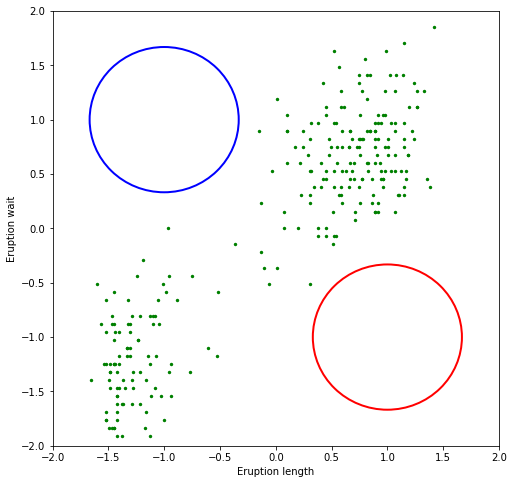

In [4]:
# Solution

# initialise the mixture components and plot

pi_0 = np.array([0.5,0.5])
mu_0 = np.array([[-1,1],[1,-1]], dtype=np.float)
Sigma_0 = np.concatenate(
    [np.eye(2).reshape(2,2,1) for _ in range(mu_0.shape[1])],
    axis=2,
)

plot_data()
plot_components(mu_0, Sigma_0, ['b','r'], 0.2)
plt.show()


## Optimise the Gaussian Mixture with EM

Using the equations you have derived, along with the relevant related material from the Bishop textbook, perform maximum likelihood estimation for $\mathbf{\mu}$, $\mathbf{\Sigma}$ and $\mathbf{\pi}$.

First implement functions that perform the E-step and the M-step, and a function that calculates the log-likelihood.
We suggest the following function signatures:

```def e_step(X, mu, Sigma, pi):```

and

```def m_step(X, gamma):```


In [5]:
# Solution

def mvn_pdf(x, mu, sigma):
    x = np.array(x).reshape(-1,1)
    mu = np.array(mu).reshape(-1,1)
    k = len(x)
    sigma = np.array(sigma).reshape(k,k)
    Z = (((2*np.pi)**k)*(np.linalg.det(sigma))) ** 0.5
    tmp = np.linalg.solve(sigma, x-mu)
    tmp = np.dot((x-mu).T,tmp)[0,0]
    rval = np.exp(-0.5*tmp) / Z
    return rval


def get_w(X, mu, Sigma, pi):
    w = np.zeros((X.shape[1], mu.shape[1]), dtype=np.float)
    for n in range(X.shape[1]):
        for k in range(mu.shape[1]):
            w[n,k] = pi[k] * mvn_pdf(X[:,n],mu[:,k],Sigma[:,:,k])
    return w
    

def e_step(X, mu, Sigma, pi):
    w = get_w(X, mu, Sigma, pi)
    gamma = w / np.sum(w, axis=1).reshape(-1,1)
    return gamma


def m_step(X, gamma):
    D = X.shape[0]
    N = gamma.shape[0]
    K = gamma.shape[1]
    assert X.shape == (D,N)
    assert np.allclose(np.sum(gamma, axis=1), 1)
    
    Nk = np.sum(gamma, axis=0)
    
    mu = X @ gamma
    mu /= Nk.reshape(1,-1)
    
    Sigma = np.zeros((D,D,K))
    for n in range(N):
        for k in range(K):
            dnk = X[:,n,None] - mu[:,k,None]
            Sigma[:,:,k] += 1 / Nk[k] * gamma[n,k] * dnk @ dnk.T
    
    pi = Nk / N
    
    return mu, Sigma, pi


def get_log_likelihood(X, mu, Sigma, pi):
    w = get_w(X, mu, Sigma, pi)
    return np.sum(np.log(np.sum(w, axis=1)), axis=0)

Check that you code is working

In [6]:
# Set the seed for the pseudo-random number generator for reproducible results.
np.random.seed(0)

# Initialise
pi, mu, Sigma = pi_0, mu_0, Sigma_0
mu += np.random.randn(np.prod(mu.shape)).reshape(mu.shape)
X = data

# One E-step followed by one M-step
gamma = e_step(X,mu,Sigma,pi)
mu, Sigma, pi = m_step(X, gamma)

# Report the log likelihood
ll = get_log_likelihood(X, mu, Sigma, pi)


### Plot EM progress

Perform 30 iterations of EM on the old faithful dataset. Every 5 iterations, plot the data and the Gaussian mixture.

*Note that the ``plot_data`` function takes an argument to control the color of the scatter plot.*

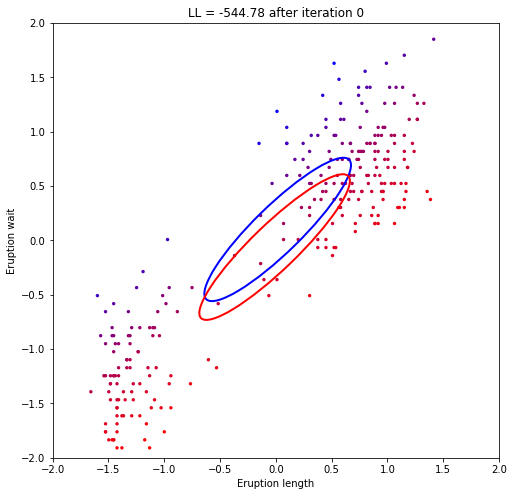

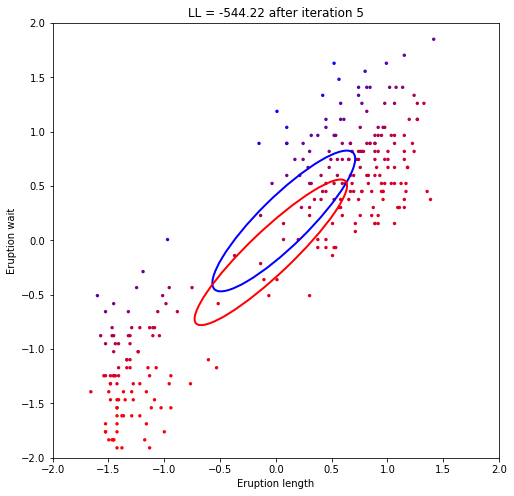

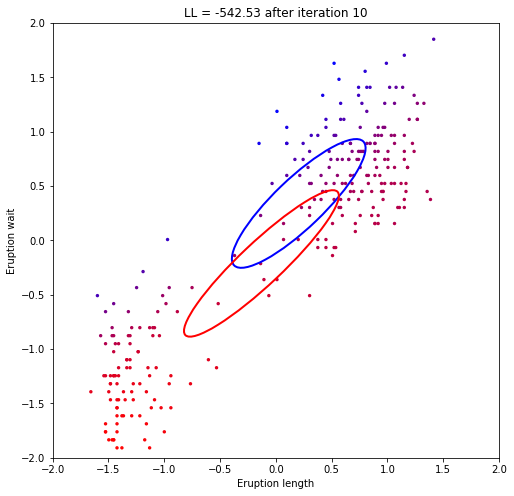

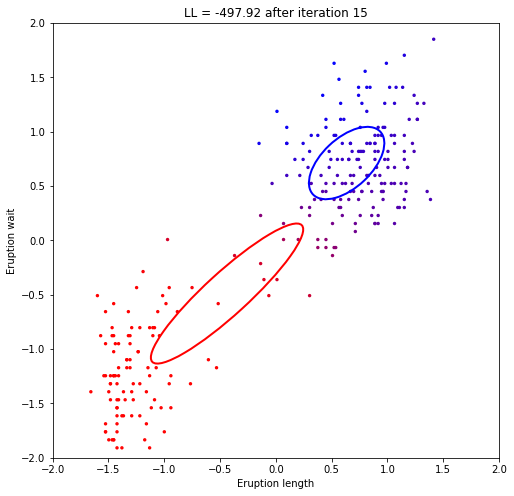

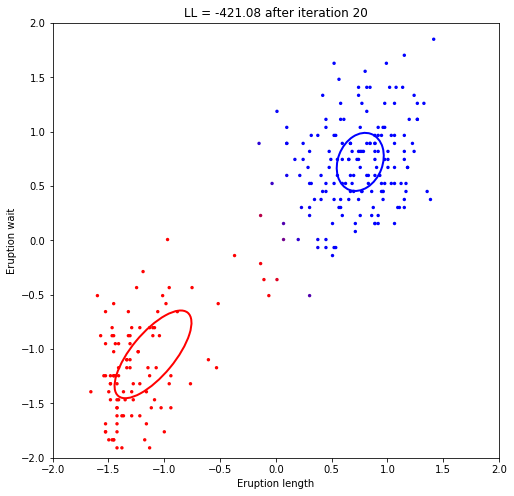

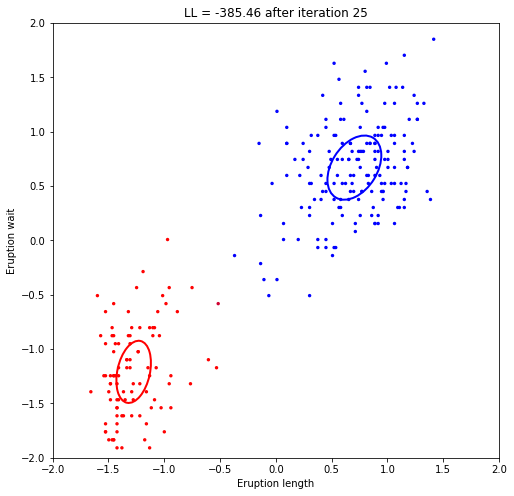

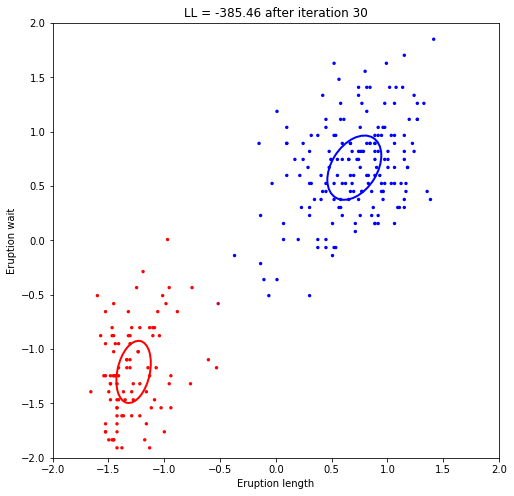

In [7]:
for iteration in range(31):

    if iteration > 0:
        mu, Sigma, pi = m_step(X, gamma)
    gamma = e_step(X, mu, Sigma,pi)
    ll = get_log_likelihood(X, mu, Sigma, pi)

    if not iteration % 5:
        plot_data(redness=gamma[:,1])
        plot_components(mu, Sigma, ['b','r'], 0.2)
        plt.title('LL = %.2f after iteration %i' % (ll, iteration))
        plt.show()

## Interpret the Previous Algorithm in terms of General EM

Refer to Bishop and/or the lecture slides, and explain with equations:
1. the assumed generative data generating process for the mixture of Gaussians,
- what the parameters of the model are,
- what the latent (unobserved) variables are and why they make maximum likelihood parameter estimation non-trivial,
- how EM provides a solution to the maximum likelihood estimation problem.

Make yourself comfortable with EM to the point that you could readily apply it to another model.

### Solution

